# Prepare Data

In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Define functions

In [14]:
def base_wav(
    wave:str,
    start:float,
    end:float,
    amp:float=1,
    f:float=1,
    phase_shift:float=0,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs)
    phase = 2*np.pi*f * times
    if wave == 'sin':
        wav = amp * np.sin(phase + phase_shift)
    if wave == 'cos':
        wav = amp * np.cos(phase + phase_shift)
    return times, wav

def signal(
    start:float,
    end:float,
    amplitudes:dict,
    modes:dict,
    phases:dict,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs) 
    signal = np.zeros(len(times))
    for wave in ('sin', 'cos'):
        if len(amplitudes[wave]) != 0 \
        and len(modes[wave]) != 0 \
        and len(phases[wave]) != 0:
            for amp, f, phase_shift in zip(amplitudes[wave], modes[wave], phases[wave]):
                _, sig = base_wav(
                    wave=wave,
                    start=start,
                    end=end,
                    amp=amp,
                    f=f,
                    phase_shift=phase_shift,
                    fs=fs,
                )
                signal += sig

    return times, signal

def gaussian(
    start:float,
    end:float,
    loc:float=0,
    scale:float=1,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs)
    signal = np.random.normal(loc=loc, scale=scale, size=len(times))
    return times, signal

## Gaussian noise and glitches

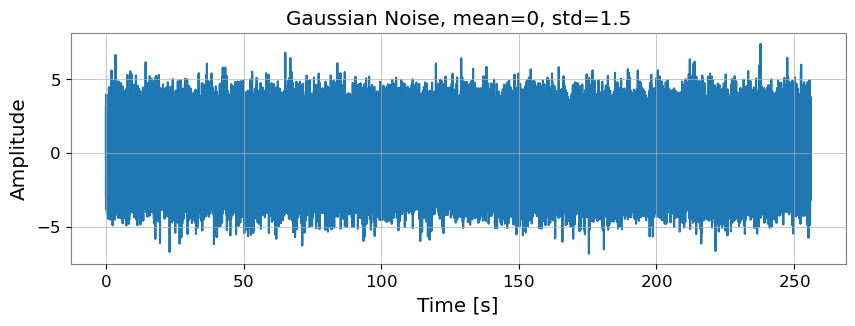

In [15]:
start = 0
end = 256
loc = 0
scale = 1.5
fs = 1024

g_times, g_noise = gaussian(
    start=start,
    end=end,
    loc=loc,
    scale=scale,
)
plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise, mean={loc}, std={scale}")
plt.plot(g_times, g_noise)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

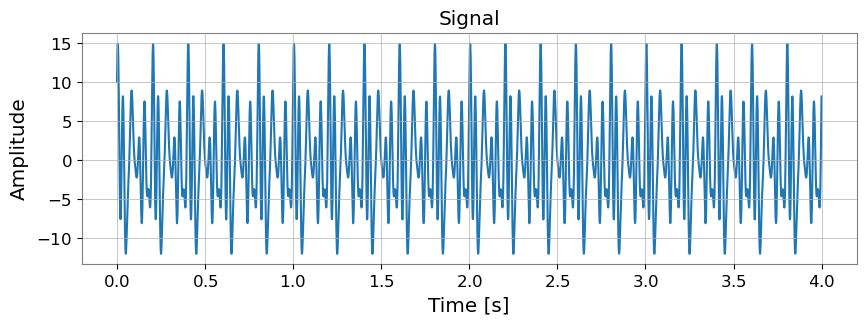

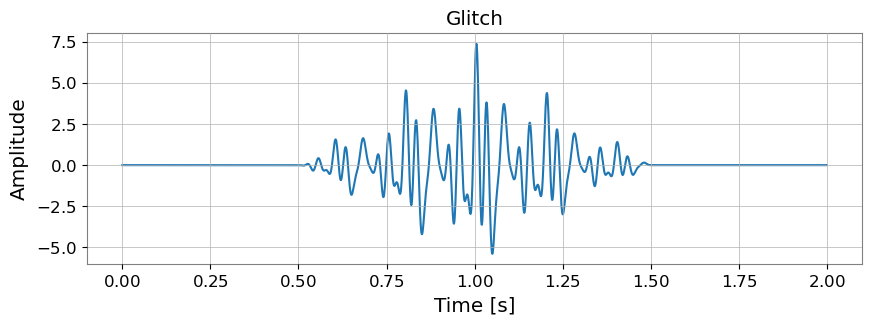

In [16]:
amplitudes = {
    "cos":[3, 5, 2],
    "sin":[3, 4, 3],
}
modes = {
    "cos":[10, 25, 30],
    "sin":[35, 15, 40],
}
phases = {
    "cos":[0, 0, 0],
    "sin":[0, 0, 0],
}

start = 0
end = 4
duration = end - start
times, sig = signal(
    start=start,
    end=end,
    amplitudes=amplitudes,
    modes=modes,
    phases=phases,
)
plt.figure(figsize=[10,3])
plt.title(f"Signal")
plt.plot(times, sig)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# # Fourier transformation
# fs = 1024
# sig_f = np.fft.rfft(sig)
# df = 1/(len(times)/fs)

# f_view = [8, 41]
# frequencies = np.arange(0, fs/2 + df, df)
# fst = int(f_view[0]/df)
# fed = int(f_view[1]/df)
# plt.figure(figsize=[10,5])
# plt.title("FFT: Amplitude")
# plt.plot(frequencies[fst:fed], np.abs(sig_f[fst:fed])/len(frequencies))
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Amplitude")
# plt.xscale('log')
# for wave in ['cos', 'sin']:
#     for amp, f in zip(amplitudes[wave], modes[wave]):
#         if amp != 0:
#             plt.axvline(f, c='red', lw=1.5, ls='--')

# plt.show()

# plt.figure(figsize=[10,5])
# plt.title("FFT: Phase")
# plt.plot(frequencies[fst:fed], np.angle(sig_f[fst:fed]))
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Phase")
# plt.xscale('log')
# for wave in ['cos', 'sin']:
#     for amp, f in zip(amplitudes[wave], modes[wave]):
#         if amp != 0:
#             plt.axvline(f, c='red', lw=1.5, ls='--')

# plt.show()

# Creating glitch time series data
fs = 1024
glitch_st = duration/2 - 0.5
glitch_ed = glitch_st + 1
pad_head = 0.5
pad_tail = 0.5
_ , glitch = signal(
    start=glitch_st,
    end=glitch_ed,
    amplitudes=amplitudes,
    modes=modes,
    phases=phases,
)
glitch_times = np.arange(0, 2, 1/fs) 
window = np.bartlett(len(glitch))
glitch *= window
pad_earlier = int(pad_head*fs)
pad_later = int(pad_tail*fs)
pad_width = (pad_earlier, pad_later)
glitch = np.pad(glitch, pad_width=pad_width, mode='constant', constant_values=(0,0))
glitch *= 0.5
plt.figure(figsize=[10,3])
plt.title(f"Glitch")
plt.plot(glitch_times, glitch)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()


## Injection of glitches

29
[129, 139, 141, 143, 145, 147, 149, 151, 153, 155, 159, 171, 175, 179, 183, 189, 193, 199, 207, 213, 215, 217, 225, 231, 235, 237, 241, 245, 247]


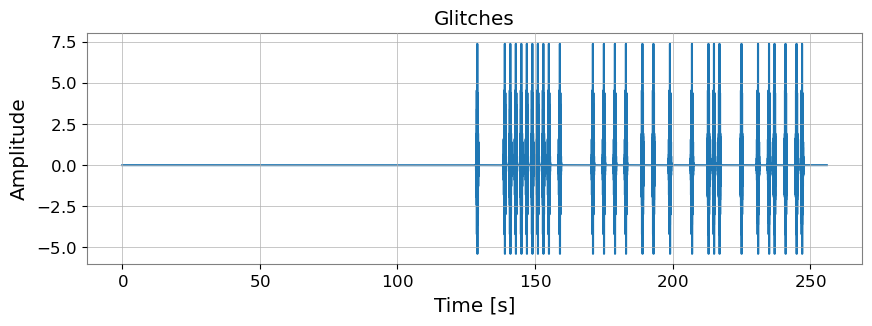

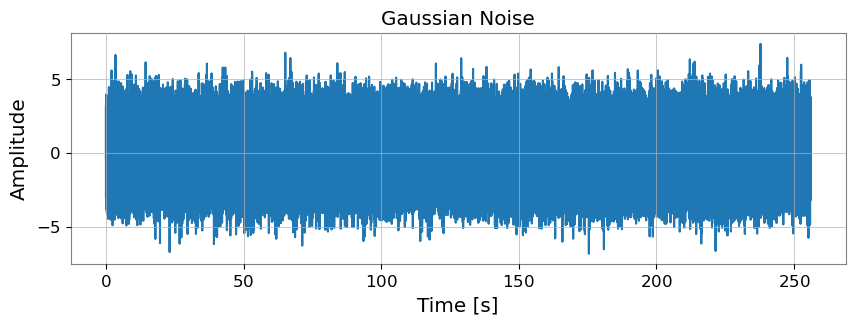

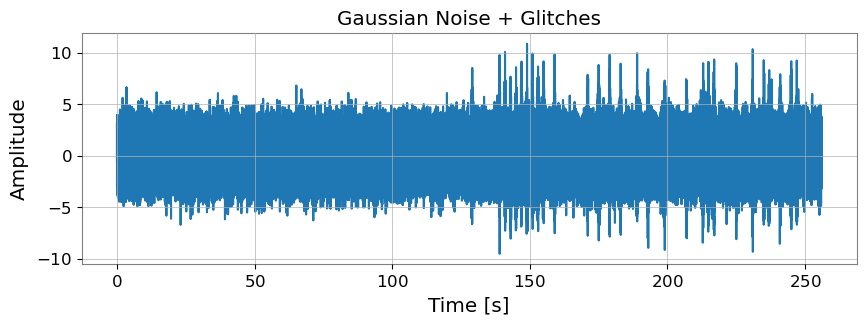

In [17]:
# Sampling the time to inject glitches
np.random.seed(2617)
glitch_n = int(len(g_noise)/fs/2)
glitch_inj = np.random.randint(0, 2, glitch_n)
for i, _ in enumerate(glitch_inj[:64]):
    glitch_inj[i] = 0

glitch_time_labels = []
if glitch_inj[0] == 1:
    glitches = glitch
    glitch_time_labels.append(0+1)
else:
    glitches = np.zeros(2*fs)

for i, inj in enumerate(glitch_inj[1:]):
    if inj == 1:
        glitches = np.append(glitches, glitch)
        glitch_time_labels.append((i+1)*2 + 1)
    else:
        glitches = np.append(glitches, np.zeros(2*fs))

print(len(glitch_time_labels))
print(glitch_time_labels)
plt.figure(figsize=[10,3])
plt.title(f"Glitches")
plt.plot(g_times, glitches)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise")
plt.plot(g_times, g_noise)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

noise = g_noise + glitches
plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise + Glitches")
plt.plot(g_times, noise)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Save time series data

In [18]:
from gwpy.timeseries import TimeSeries

In [19]:
# Create gwpy TimeSeries
t0 = 1234567890
sample_rate = fs
duration = int(len(g_noise)/fs)
g_noise_ts = TimeSeries(
    g_noise,
    t0=t0,
    sample_rate=sample_rate,
    channel="EX:GAUSSIAN_EXAMPLE",
    name="EX:GAUSSIAN_EXAMPLE",
)
noise_ts = TimeSeries(
    noise,
    t0=t0,
    sample_rate=sample_rate,
    channel="EX:NOISE_EXAMPLE",
    name="EX:NOISE_EXAMPLE",
)

# Save data to gwf files, please change the paths accordingly.
root_dir = "/home/jerry/glitch-classification"
gaussian_gwf = f"{root_dir}/Data/EX-GAUSSIAN-{t0}-{duration}.gwf"
noise_gwf = f"{root_dir}/Data/EX-NOISE-{t0}-{duration}.gwf"
g_noise_ts.write(gaussian_gwf)
noise_ts.write(noise_gwf)

## Run Omicron

In [20]:
# Making working directory for Omicron
import os
working_dir = f"{root_dir}/Omicron"
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

trigger_dir = f"{working_dir}/triggers"
if not os.path.exists(trigger_dir):
    os.mkdir(trigger_dir)

# Setup config files for Omicron
labels = ["EX_GAUSSIAN_EXAMPLE", "EX_NOISE_EXAMPLE"]
for label in labels:
    # Generating lcf file
    os.chdir(working_dir)
    if label ==  "EX_GAUSSIAN_EXAMPLE":
        gwf_file = gaussian_gwf
    if label ==  "EX_NOISE_EXAMPLE":
        gwf_file = noise_gwf

    lcf_content = f"EX {label} {t0} {duration} {gwf_file}"
    lcf_file = f"{working_dir}/frames.lcf"
    with open(lcf_file, 'w') as file:
        file.write(lcf_content)

    # Generating parameters.txt
    parameter_content = f"""\
# Omicron parameter file
 
PARAMETER CLUSTERING       TIME
PARAMETER FFTPLAN          FFTW_ESTIMATE
PARAMETER TRIGGERRATEMAX   100000
PARAMETER QRANGE           3.3166 108.0
PARAMETER FREQUENCYRANGE   32.0 2048.0
PARAMETER CLUSTERDT        0.5
PARAMETER MISMATCHMAX      0.2
PARAMETER SNRTHRESHOLD     6.0 
PARAMETER PSDLENGTH        124
PARAMETER TIMING           64 4

OUTPUT    DIRECTORY        {trigger_dir}
OUTPUT    PRODUCTS         triggers
OUTPUT    VERBOSITY        1
OUTPUT    FORMAT           hdf5
OUTPUT    NTRIGGERMAX      10000000.0

DATA      SAMPLEFREQUENCY  1024
DATA      FFL              {lcf_file}
DATA      CHANNELS         {label.replace('_', ':', 1)}
    """
    parameter_file = f"{working_dir}/parameters.txt"
    with open(parameter_file, 'w') as file:
        file.write(parameter_content)

    # Run Omicron
    os.chdir(working_dir)
    # Clear the previous results:
    import shutil
    output_dir = f"{working_dir}/triggers/{label.replace('_', ':', 1)}"
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    print(t0, t0+duration)
    # Command to run Omicron:
    os.system(f"omicron {t0} {t0 + duration} {parameter_file} strict")
    # Clear ffl files:
    os.system(f"rm {working_dir}/triggers/*.ffl")
    os.chdir(root_dir)

1234567890 1234568146


C system headers (glibc/Xcode/Windows SDK) must be installed.
In file included from input_line_4:36:
/home/jerry/micromamba/envs/glitch-classification/bin/../lib/gcc/x86_64-conda-linux-gnu/13.3.0/include/c++/cassert:44:10: fatal error: 'assert.h' file not found
#include <assert.h>
         ^~~~~~~~~~




##############################################################
##############################################################

   ██████╗ ███╗   ███╗██╗ ██████╗██████╗  ██████╗ ███╗   ██╗
  ██╔═══██╗████╗ ████║██║██╔════╝██╔══██╗██╔═══██╗████╗  ██║
  ██║   ██║██╔████╔██║██║██║     ██████╔╝██║   ██║██╔██╗ ██║
  ██║   ██║██║╚██╔╝██║██║██║     ██╔══██╗██║   ██║██║╚██╗██║
  ╚██████╔╝██║ ╚═╝ ██║██║╚██████╗██║  ██║╚██████╔╝██║ ╚████║
   ╚═════╝ ╚═╝     ╚═╝╚═╝ ╚═══��═╝╚═╝  ╚═╝ ╚═════╝ ╚═╝  ╚═══╝
                                                    4.1.1
##############################################################
##############################################################


IO::ParseFile: Parse file /home/jerry/glitch-classification/Omicron/parameters.txt		ok
Omicron::ReadOptions: number of options = 43
ffl::ffl: detect file format
ffl::Convert2Ffl: FFL conversion
ffl::Reset: reset ffl
ffl::LoadFrameFile: load FFL file
ffl::LoadFrameFile: extract frame information
ffl::LoadFrameFile: ch

C system headers (glibc/Xcode/Windows SDK) must be installed.
In file included from input_line_4:36:
/home/jerry/micromamba/envs/glitch-classification/bin/../lib/gcc/x86_64-conda-linux-gnu/13.3.0/include/c++/cassert:44:10: fatal error: 'assert.h' file not found
#include <assert.h>
         ^~~~~~~~~~




##############################################################
##############################################################

   ██████╗ ███╗   ███╗██╗ ██████╗██████╗  ██████╗ ███╗   ██╗
  ██╔═══██╗████╗ ████║██║██╔════╝██╔══██╗██╔═══██╗████╗  ██║
  ██║   ██║██╔████╔██║██║██║     ██████╔╝██║   ██║██╔██╗ ██║
  ██║   ██║██║╚██╔╝██║██║██║     ██╔══██╗██║   ██║██║╚██╗██║
  ╚██████╔╝██║ ╚═╝ ██║██║╚██████╗██║  ██║╚██████╔╝██║ ╚████║
   ╚═════╝ ╚═╝     ╚═╝╚═╝ ╚═══��═╝╚═╝  ╚═╝ ╚═════╝ ╚═╝  ╚═══╝
                                                    4.1.1
##############################################################
##############################################################


IO::ParseFile: Parse file /home/jerry/glitch-classification/Omicron/parameters.txt		ok
Omicron::ReadOptions: number of options = 43
ffl::ffl: detect file format
ffl::Convert2Ffl: FFL conversion
ffl::Reset: reset ffl
ffl::LoadFrameFile: load FFL file
ffl::LoadFrameFile: extract frame information
ffl::LoadFrameFile: ch

## Check triggers

In [21]:
import h5py 
import glob

0
[]


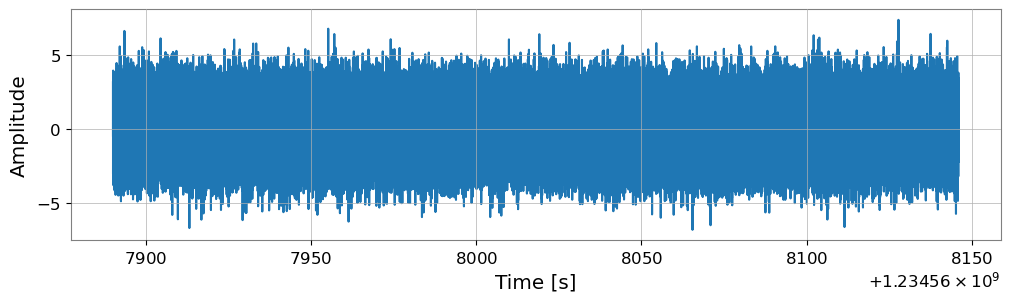

In [22]:
# Check Gaussian noise
label = "EX_GAUSSIAN_EXAMPLE"
h5s = glob.glob(f"{working_dir}/triggers/{label.replace('_', ':', 1)}/*.h5")
h5s = sorted(h5s)
triggers = []
for h5 in h5s[:]:
    with h5py.File(h5, 'r') as f:
        # print(f.keys())
        # print(f['triggers'])
        triggers.extend(f['triggers'][:])

# Check how many triggers are reported
print(len(triggers))
# Check one of the triggers
# id = 0
# print(triggers[id].dtype)
# print(f"time: {triggers[id]['time']}")
# print(f"frequency: {triggers[id]['frequency']}")
# print(f"q: {triggers[id]['q']}")
# print(f"snr: {triggers[id]['snr']}")

# Check the time of all triggers
trigger_times = [trigger['time'] for trigger in triggers]
print(trigger_times)
# Plot noise time series data
plt.figure(figsize=[12,3])
plt.plot(g_noise_ts.times, g_noise_ts)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
for t in trigger_times:
    plt.axvline(t, c='r', lw=1.3)
plt.show()

29
{'names': ['time', 'frequency', 'tstart', 'tend', 'fstart', 'fend', 'snr', 'q', 'amplitude', 'phase'], 'formats': ['<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8'], 'offsets': [0, 8, 48, 56, 64, 72, 16, 24, 32, 40], 'itemsize': 80}
time: 1234568019.019531
frequency: 35.12830434456701
q: 4.698606594343501
snr: 14.619421233549222
Time labels of the glitches triggered by Omicron:
[1234568019.019531, 1234568029.011718, 1234568031.011718, 1234568033.019531, 1234568035.019531, 1234568037.011718, 1234568039.019531, 1234568041.019531, 1234568043.011718, 1234568045.019531, 1234568049.011718, 1234568061.019531, 1234568065.011718, 1234568069.019531, 1234568073.023437, 1234568079.019531, 1234568083.019531, 1234568089.023437, 1234568097.019531, 1234568103.0625, 1234568105.019531, 1234568107.027343, 1234568115.011718, 1234568121.019531, 1234568125.019531, 1234568127.011718, 1234568131.011718, 1234568135.011718, 1234568137.011718]


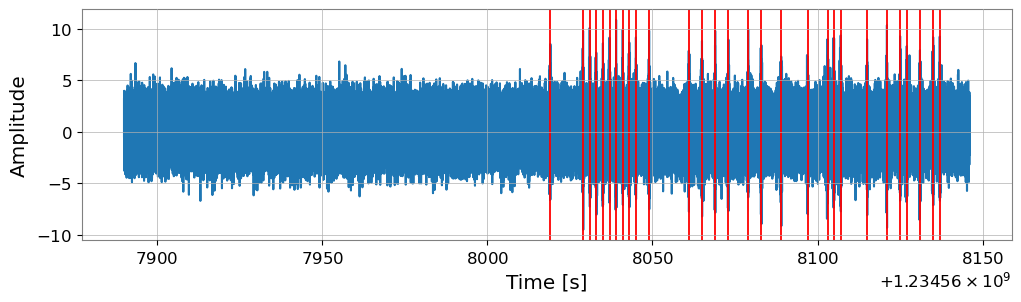

The time labels of the injected glitches:
29
[1234568019 1234568029 1234568031 1234568033 1234568035
 1234568037 1234568039 1234568041 1234568043 1234568045
 1234568049 1234568061 1234568065 1234568069 1234568073
 1234568079 1234568083 1234568089 1234568097 1234568103
 1234568105 1234568107 1234568115 1234568121 1234568125
 1234568127 1234568131 1234568135 1234568137]


In [23]:
# Check noise with glitches
label = "EX_NOISE_EXAMPLE"
h5s = glob.glob(f"{working_dir}/triggers/{label.replace('_', ':', 1)}/*.h5")
h5s = sorted(h5s)
triggers = []
for h5 in h5s[:]:
    with h5py.File(h5, 'r') as f:
        # print(f.keys())
        # print(f['triggers'])
        triggers.extend(f['triggers'][:])

# Check how many triggers are reported:
print(len(triggers))
# Check one of the triggers:
id = 0
print(triggers[id].dtype)
print(f"time: {triggers[id]['time']}")
print(f"frequency: {triggers[id]['frequency']}")
print(f"q: {triggers[id]['q']}")
print(f"snr: {triggers[id]['snr']}")
# Check the time of all triggers:
trigger_times = [float(trigger['time']) for trigger in triggers]
print("Time labels of the glitches triggered by Omicron:")
print(trigger_times)
# Plot noise time series data:
# noise_ts.plot().show()

plt.figure(figsize=[12,3])
plt.plot(noise_ts.times, noise_ts)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
for t in trigger_times:
    plt.axvline(t, c='r', lw=1.3)
plt.show()

# The real time of injected glitches
print("The time labels of the injected glitches:")
inj_glitch_times = np.array(glitch_time_labels)
inj_glitch_times += 1234567890
print(len(inj_glitch_times))
print(inj_glitch_times)

## Q-transform

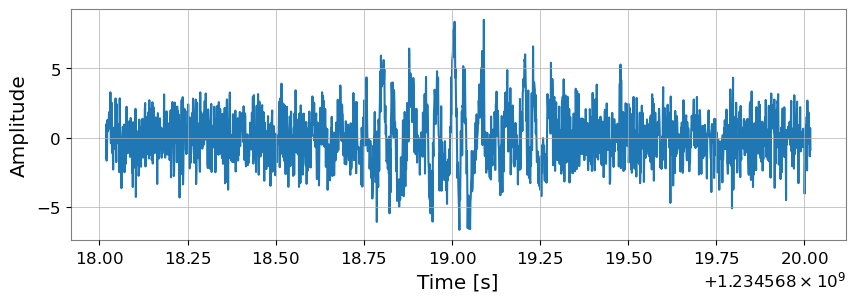

Shape of the spectrogram: (1000, 500)
Value of the spectrogram: [[ 1.          0.9999971   0.9999949  ...  0.175647
   0.25346187  0.25346187]
 [ 1.          0.9999974   0.99999535 ...  0.24701564
   0.31925276  0.31925276]
 [ 1.          0.9999977   0.9999959  ...  0.32849768
   0.3993125   0.3993125 ]
 ...
 [ 1.          1.0000191   1.0000335  ... -0.25121468
  -0.01903004 -0.01903004]
 [ 1.          1.0000196   1.0000345  ... -0.33689395
  -0.06263118 -0.06263118]
 [ 1.          1.0000201   1.0000353  ... -0.43605965
  -0.11681906 -0.11681906]]


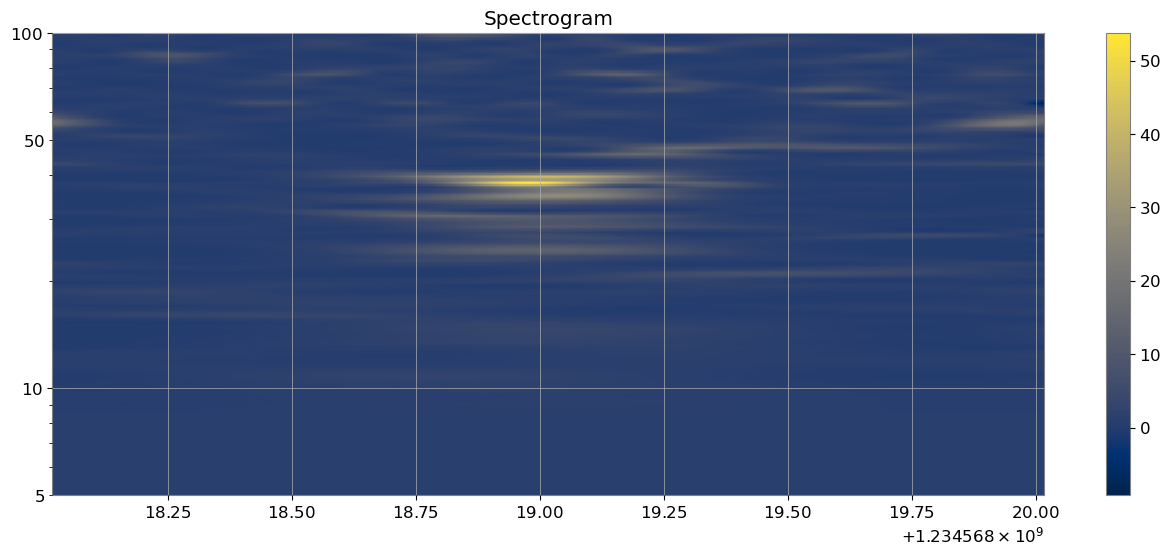

In [24]:
gwf_file = noise_gwf
channel = "EX:NOISE_EXAMPLE"
trigger_id = 0
start = trigger_times[trigger_id] - 1
end = start + 2
ts = TimeSeries.read(
    source=noise_gwf,
    start=start,
    end=end,
    channel=channel,
)
# Plot time series
plt.figure(figsize=[10,3])
plt.plot(ts.times, ts)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# Q-transform
q_spec = ts.q_transform(
    qrange=[50,50],
    frange=[5,256],
    logf=True,
    whiten=False,
)
amplitude = q_spec.T.to_value()
times = q_spec.times.to_value()
frequencies = q_spec.frequencies.to_value()
# Check the spectrogram:
print(f"Shape of the spectrogram: {q_spec.value.shape}")
print(f"Value of the spectrogram: {q_spec.value}")

# Plot the spectrogram
plt.figure(figsize=[16,6])
plt.title(f"Spectrogram")
plt.pcolormesh(
    times,
    frequencies,
    amplitude,
    # vmax=10,
    cmap='cividis',
)
plt.yscale('log')
plt.ylim((5, 100))
plt.colorbar(cmap='cividis')
plt.show()